In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 11 18:39:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install transformers

In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
from torch.utils.data import TensorDataset

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def clean_text(text):
    if isinstance(text, (str, np.ndarray)): 
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        elif isinstance(text, np.ndarray):
            return np.array([clean_text(t) for t in text])
    elif pd.isnull(text): 
        return ""
    else:
        try:
            text = str(text)
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        except Exception as e:
            print(f"Error cleaning text: {e}, Text Type: {type(text)}, Text Value: {text}")
            return "" 

In [ ]:
labeled_data = pd.read_csv("data/WoSDataset_53949.csv")

for col in ['Keywords', 'Abstract']:
    labeled_data[col] = labeled_data[col].apply(clean_text)

labeled_data['combined_text'] = labeled_data['Keywords'] + " [SEP] " + labeled_data['Abstract']

In [4]:
abstractslbl = labeled_data['Abstract']
keywordsslbl = labeled_data['Keywords']
domainlbl = labeled_data['Domain']
lbls = labeled_data['Label']

In [5]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(53949, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [6]:
labels = np.unique(domainlbl, return_counts=True)[0]
labelCounts=  np.unique(domainlbl, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 7773  5000  6303  4472 15641  8089  6671]


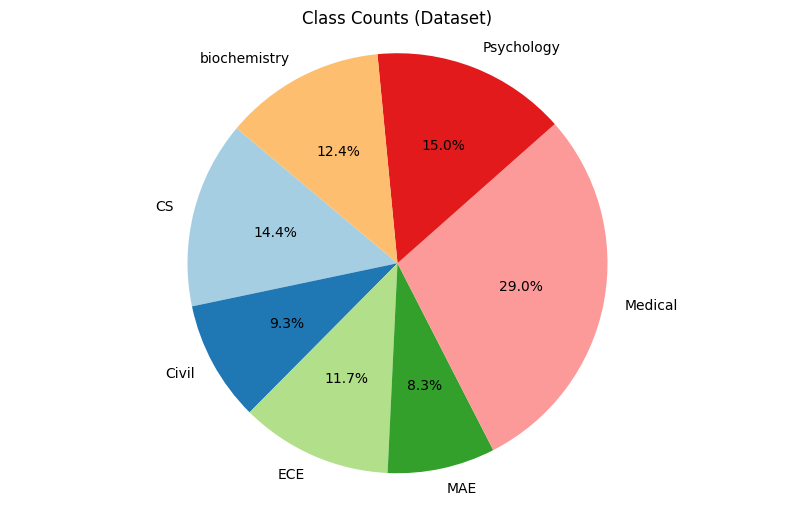

The label CS has 7773 records in the dataset.
The label Civil has 5000 records in the dataset.
The label ECE has 6303 records in the dataset.
The label MAE has 4472 records in the dataset.
The label Medical has 15641 records in the dataset.
The label Psychology has 8089 records in the dataset.
The label biochemistry has 6671 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [8]:
labeled_data_shuffled = sklearn.utils.shuffle(labeled_data)
abstracts_shuffled = labeled_data_shuffled['Abstract'].values
keywords_shuffled = labeled_data_shuffled['Keywords'].values
domains_shuffled = labeled_data_shuffled['Domain'].values
allLabels_shuffled = labeled_data_shuffled['Label'].values
allLabels_digit_shuffled = allLabels_shuffled.astype(int)

In [9]:
print(np.shape(labeled_data_shuffled))
print(np.shape(abstracts_shuffled))
print(np.shape(keywords_shuffled))
print(np.shape(domains_shuffled))

print(labeled_data_shuffled['combined_text'][0])

(53949, 5)
(53949,)
(53949,)
(53949,)
 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction         [SEP] 2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional

In [ ]:
train_data, test_data = train_test_split(labeled_data_shuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

_, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))



(43159, 5)
(10790, 5)
(43159, 5)
(10790, 5)
(5395, 5)


In [11]:
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
abstractslbltrain = train_data['Abstract']
keywordsslbltrain = train_data['Keywords']
domainlbltrain = train_data['Domain']
lblstrain = train_data['Label']

In [13]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(53949, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [14]:
labels = np.unique(domainlbltrain, return_counts=True)[0]
labelCounts=  np.unique(domainlbltrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6198  4039  5065  3616 12523  6462  5256]


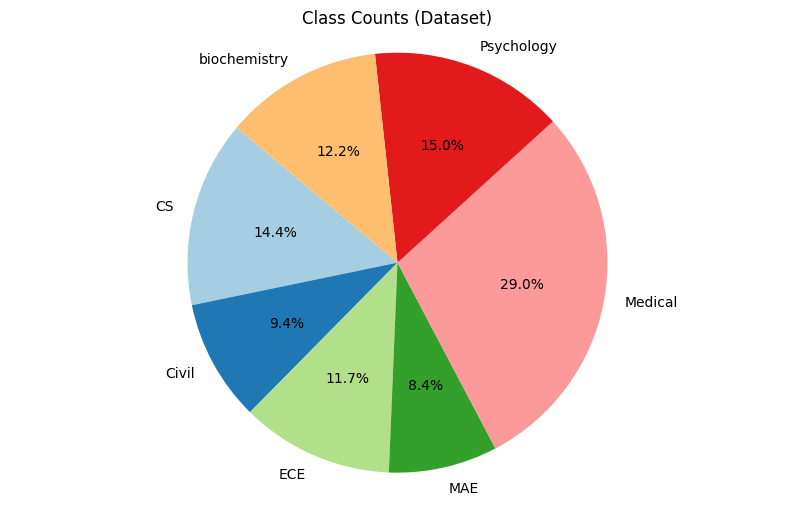

The label CS has 6198 records in the dataset.
The label Civil has 4039 records in the dataset.
The label ECE has 5065 records in the dataset.
The label MAE has 3616 records in the dataset.
The label Medical has 12523 records in the dataset.
The label Psychology has 6462 records in the dataset.
The label biochemistry has 5256 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [16]:
abstractslbltest = test_data['Abstract']
keywordsslbltest = test_data['Keywords']
domainlbltest = test_data['Domain']
lblstest = test_data['Label']

In [17]:
labels = np.unique(domainlbltest, return_counts=True)[0]
labelCounts=  np.unique(domainlbltest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1575  961 1238  856 3118 1627 1415]


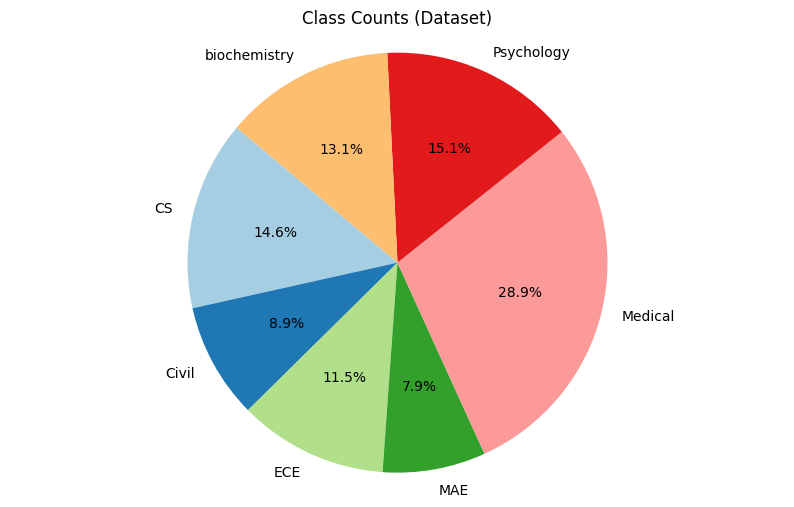

The label CS has 1575 records in the dataset.
The label Civil has 961 records in the dataset.
The label ECE has 1238 records in the dataset.
The label MAE has 856 records in the dataset.
The label Medical has 3118 records in the dataset.
The label Psychology has 1627 records in the dataset.
The label biochemistry has 1415 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [19]:
abstractslblval = val_data['Abstract']
keywordsslblval = val_data['Keywords']
domainlblval = val_data['Domain']
lblsval = val_data['Label']

In [20]:
labels = np.unique(domainlblval, return_counts=True)[0]
labelCounts=  np.unique(domainlblval, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 755  477  607  457 1564  826  709]


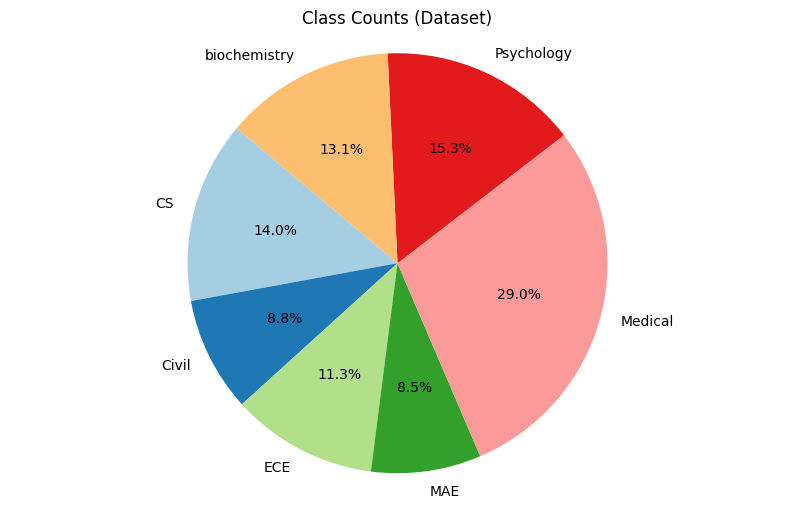

The label CS has 755 records in the dataset.
The label Civil has 477 records in the dataset.
The label ECE has 607 records in the dataset.
The label MAE has 457 records in the dataset.
The label Medical has 1564 records in the dataset.
The label Psychology has 826 records in the dataset.
The label biochemistry has 709 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
def encode_data(data, tokenizer, max_length=128, labeled=True):
    inputs = tokenizer(
        data['combined_text'].tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    if labeled and 'Label' in data.columns:
        labels = torch.tensor(data['Label'].values.astype(int))
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    else:
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'])


In [23]:
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)

In [24]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

In [25]:
print(len(np.unique(train_data['Label'])))
model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", num_labels=len(np.unique(train_data['Label'])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [26]:
def calculate_metrics_f(valType, predictions, true_labels):
    if valType == 'test':
        cm = confusion_matrix(true_labels, predictions)
        report = classification_report(true_labels, predictions)
        f1_micro = f1_score(true_labels, predictions, average='micro')
        print("\nClassification Report:\n", report)
        return f1_micro
    elif valType == 'val':
        f1_micro = f1_score(true_labels, predictions, average='micro')
        return f1_micro

In [27]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [ ]:

epochs = 20
learning_rates = [2e-5, 5e-6, 1e-6, 2e-6]
early_stopping_patience = 3
best_val_f1 = 0
early_stopping_counter = 0

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            model.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

        # Validation
        model.eval()
        predictions, true_labels = [], []
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            batch_predictions = np.argmax(logits, axis=1)
            predictions.extend(batch_predictions)
            true_labels.extend(labels.to('cpu').numpy())
        val_f1 = f1_score(true_labels, predictions, average='micro')
        print(f"Validation Micro F1: {val_f1}")
        val_micro_f1 = calculate_metrics_f('val', predictions, true_labels)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Val Micro F1: {val_micro_f1}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved.")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping applied.")
                break

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded.")


Training with learning rate: 2e-05


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/20: 100%|██████████| 1349/1349 [2:34:51<00:00,  6.89s/batch] 


Train Loss: 1.0529650758932572
Validation Micro F1: 0.8472659870250232
Epoch 1/20, Train Loss: 1.0529650758932572, Val Micro F1: 0.8472659870250232
Best model saved.


Epoch 2/20: 100%|██████████| 1349/1349 [2:37:59<00:00,  7.03s/batch] 


Train Loss: 0.39968915755347556
Validation Micro F1: 0.8795180722891566
Epoch 2/20, Train Loss: 0.39968915755347556, Val Micro F1: 0.8795180722891566
Best model saved.


Epoch 3/20: 100%|██████████| 1349/1349 [2:40:24<00:00,  7.13s/batch] 


Train Loss: 0.29027574487013935
Validation Micro F1: 0.8845227062094532
Epoch 3/20, Train Loss: 0.29027574487013935, Val Micro F1: 0.8845227062094532
Best model saved.


Epoch 4/20: 100%|██████████| 1349/1349 [2:39:27<00:00,  7.09s/batch] 


Train Loss: 0.18630645242350533
Validation Micro F1: 0.8895273401297498
Epoch 4/20, Train Loss: 0.18630645242350533, Val Micro F1: 0.8895273401297498
Best model saved.


Epoch 5/20: 100%|██████████| 1349/1349 [2:39:51<00:00,  7.11s/batch] 


Train Loss: 0.10717222774801727
Validation Micro F1: 0.890454124189064
Epoch 5/20, Train Loss: 0.10717222774801727, Val Micro F1: 0.890454124189064
Best model saved.


Epoch 6/20: 100%|██████████| 1349/1349 [2:39:40<00:00,  7.10s/batch] 


Train Loss: 0.06338133779690953
Validation Micro F1: 0.8878591288229842
Epoch 6/20, Train Loss: 0.06338133779690953, Val Micro F1: 0.8878591288229842


Epoch 7/20: 100%|██████████| 1349/1349 [2:37:33<00:00,  7.01s/batch] 


Train Loss: 0.04272214866749351
Validation Micro F1: 0.8810009267840593
Epoch 7/20, Train Loss: 0.04272214866749351, Val Micro F1: 0.8810009267840593


Epoch 8/20: 100%|██████████| 1349/1349 [2:38:11<00:00,  7.04s/batch] 


Train Loss: 0.028693829948785717


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8848934198331788
Epoch 8/20, Train Loss: 0.028693829948785717, Val Micro F1: 0.8848934198331788
Early stopping applied.

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 1349/1349 [2:42:07<00:00,  7.21s/batch] 


Train Loss: 0.011990615273225626


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8878591288229842
Epoch 1/20, Train Loss: 0.011990615273225626, Val Micro F1: 0.8878591288229842
Early stopping applied.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 1349/1349 [2:38:47<00:00,  7.06s/batch] 


Train Loss: 0.0052809764099845165


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8876737720111214
Epoch 1/20, Train Loss: 0.0052809764099845165, Val Micro F1: 0.8876737720111214
Early stopping applied.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 1349/1349 [2:39:19<00:00,  7.09s/batch] 


Train Loss: 0.004636027888300224
Validation Micro F1: 0.8891566265060241
Epoch 1/20, Train Loss: 0.004636027888300224, Val Micro F1: 0.8891566265060241
Early stopping applied.


/tmp/ipykernel_1215199/2884164286.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Best model loaded.


In [29]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1405   38    9   23   27   20   53]
 [  18 1153    5   30   22    9    1]
 [  18    6 1326   13   13  219   32]
 [  10   25    5  769   17   18   12]
 [  11   15    6   24  881   11   13]
 [  22    3  131   10    5 2757  190]
 [  10    0   12    4    7  147 1235]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      1575
           1       0.93      0.93      0.93      1238
           2       0.89      0.81      0.85      1627
           3       0.88      0.90      0.89       856
           4       0.91      0.92      0.91       961
           5       0.87      0.88      0.88      3118
           6       0.80      0.87      0.84      1415

    accuracy                           0.88     10790
   macro avg       0.89      0.89      0.89     10790
weighted avg       0.88      0.88      0.88     10790

Macro F1 Score: 0.8870534240284321
Micro F1 Score: 0.8828544949026876
Weighted F1 Score: 0.8

In [30]:
# Calculate and display test metrics
print("\nTest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))
print("Macro F1:", f1_score(true_labels, predictions, average='macro'))
print("Micro F1:", f1_score(true_labels, predictions, average='micro'))
print("Weighted F1:", f1_score(true_labels, predictions, average='weighted'))


Test Metrics:
Confusion Matrix:
 [[1405   38    9   23   27   20   53]
 [  18 1153    5   30   22    9    1]
 [  18    6 1326   13   13  219   32]
 [  10   25    5  769   17   18   12]
 [  11   15    6   24  881   11   13]
 [  22    3  131   10    5 2757  190]
 [  10    0   12    4    7  147 1235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      1575
           1       0.93      0.93      0.93      1238
           2       0.89      0.81      0.85      1627
           3       0.88      0.90      0.89       856
           4       0.91      0.92      0.91       961
           5       0.87      0.88      0.88      3118
           6       0.80      0.87      0.84      1415

    accuracy                           0.88     10790
   macro avg       0.89      0.89      0.89     10790
weighted avg       0.88      0.88      0.88     10790

Macro F1: 0.8870534240284321
Micro F1: 0.8828544949026876
Weighted F1: 0.88302

In [31]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
model.save_pretrained('BlueBERT_WoS_53949_records')

In [32]:
print('End of the runtime!')

End of the runtime!
